In [1]:
!pip install tensorflow


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import timeseries_dataset_from_array
import matplotlib.pyplot as plt

In [8]:
# Cargar los datos
data_file = 'jena_climate_2009_2016.csv'  
data = pd.read_csv(data_file)

# Análisis descriptivo de los datos
print(data.describe())

# Seleccionar las características (inputs) y el objetivo (outputs)
inputs = data.iloc[:, [1] + list(range(5, 15))]  # Cambia según las columnas seleccionadas
outputs = data['T (degC)']  # Supongamos que esta es la columna de temperatura

# Estandarizar las características de entrada
scaler = StandardScaler()
inputs_scaled = scaler.fit_transform(inputs)

# Convertir a formato Numpy para facilitar el manejo
X = inputs_scaled
y = outputs.to_numpy()


            p (mbar)       T (degC)       Tpot (K)    Tdew (degC)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean      989.212776       9.450147     283.492743       4.955854   
std         8.358481       8.423365       8.504471       6.730674   
min       913.600000     -23.010000     250.600000     -25.010000   
25%       984.200000       3.360000     277.430000       0.240000   
50%       989.580000       9.420000     283.470000       5.220000   
75%       994.720000      15.470000     289.530000      10.070000   
max      1015.350000      37.280000     311.340000      23.110000   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  420551.000000  420551.000000  420551.000000  420551.000000   
mean       76.008259      13.576251       9.533756       4.042412   
std        16.476175       7.739020       4.184164       4.896851   
min        12.950000       0.950000       0.790000       0.000000   
25%        65.210000       7.7800

In [10]:
# Dividir los datos en entrenamiento, validación y prueba
No_train = 210275
No_val = 105138
No_test = 105138

# Normalizar los datos de entrada
media = X[:No_train].mean(axis=0)
std = X[:No_train].std(axis=0)
X = (X - media) / std

# Configurar el muestreo y crear los datasets de serie temporal
sampling_rate = 6           # Tomar un dato cada hora (datos cada 10 minutos)
sequence_length = 120       # Ventana de 120 horas para predecir
delay = sampling_rate * (sequence_length + 24 - 1)  # Predicción a 24 horas
batch_size = 256            # Tamaño de lote para el entrenamiento

# Crear los conjuntos de datos
train_dataset = timeseries_dataset_from_array(
    X[:-delay], y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=0, end_index=No_train
)

val_dataset = timeseries_dataset_from_array(
    X[:-delay], y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=No_train, end_index=No_train + No_val
)

test_dataset = timeseries_dataset_from_array(
    X[:-delay], y[delay:], sampling_rate=sampling_rate, sequence_length=sequence_length,
    shuffle=True, batch_size=batch_size, start_index=No_train + No_val
)

# Crear el modelo LSTM ajustado
model_adjusted = Sequential([
    LSTM(128, input_shape=(sequence_length, X.shape[-1]), recurrent_dropout=0.3, return_sequences=True),
    Dropout(0.3),
    LSTM(64, recurrent_dropout=0.3),
    Dense(1)
])

# Compilar el modelo ajustado
model_adjusted.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo ajustado
history_adjusted = model_adjusted.fit(
    train_dataset,
    epochs=30,  # Ajusta el número de épocas según el desempeño
    validation_data=val_dataset
)


Epoch 1/30


C:\Users\Usuario\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


819/819 ━━━━━━━━━━━━━━━━━━━━ 570s 691ms/step - loss: 30.5763 - mae: 4.0067 - val_loss: 9.5744 - val_mae: 2.3983
Epoch 2/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 569s 694ms/step - loss: 9.4463 - mae: 2.4076 - val_loss: 9.3166 - val_mae: 2.3814
Epoch 3/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 564s 688ms/step - loss: 7.8122 - mae: 2.1965 - val_loss: 9.9936 - val_mae: 2.4528
Epoch 4/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 564s 689ms/step - loss: 6.3878 - mae: 1.9840 - val_loss: 10.7758 - val_mae: 2.5376
Epoch 5/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 564s 688ms/step - loss: 5.1720 - mae: 1.7798 - val_loss: 11.4349 - val_mae: 2.6005
Epoch 6/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 562s 686ms/step - loss: 4.2714 - mae: 1.6140 - val_loss: 11.9897 - val_mae: 2.6733
Epoch 7/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 554s 676ms/step - loss: 3.6422 - mae: 1.4859 - val_loss: 12.2947 - val_mae: 2.7138
Epoch 8/30
819/819 ━━━━━━━━━━━━━━━━━━━━ 557s 679ms/step - loss: 3.1917 - mae: 1.3895 - val_loss: 12.3561 - val_mae: 2.7113
Epoch 9/30
819/819 ━━━━━━━━━━

In [12]:
# Evaluar el modelo ajustado en el conjunto de prueba
test_loss_adjusted, test_mae_adjusted = model_adjusted.evaluate(test_dataset)
print(f"MAE en el conjunto de prueba ajustado: {test_mae_adjusted:.2f}")

# Calcular la calificación del modelo ajustado
MAE_max = 2.5  # Define un MAE máximo aceptable basado en el contexto o datos históricos
calificacion_adjusted = 5.0 * (2.5 - test_mae_adjusted) / (2.5 - MAE_max)
print(f"Calificación del modelo ajustado: {calificacion_adjusted:.2f}")


405/405 ━━━━━━━━━━━━━━━━━━━━ 81s 199ms/step - loss: 14.4702 - mae: 3.0289
MAE en el conjunto de prueba ajustado: 3.03


ZeroDivisionError: float division by zero

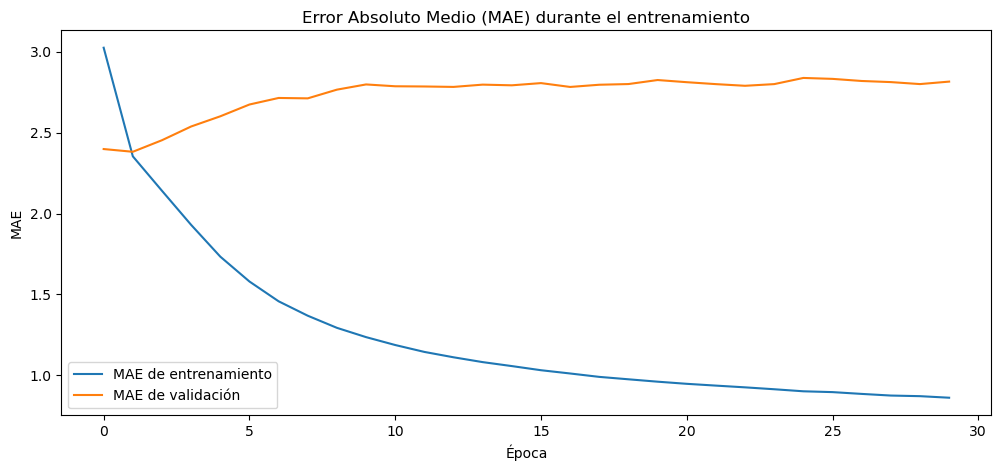

405/405 ━━━━━━━━━━━━━━━━━━━━ 81s 199ms/step


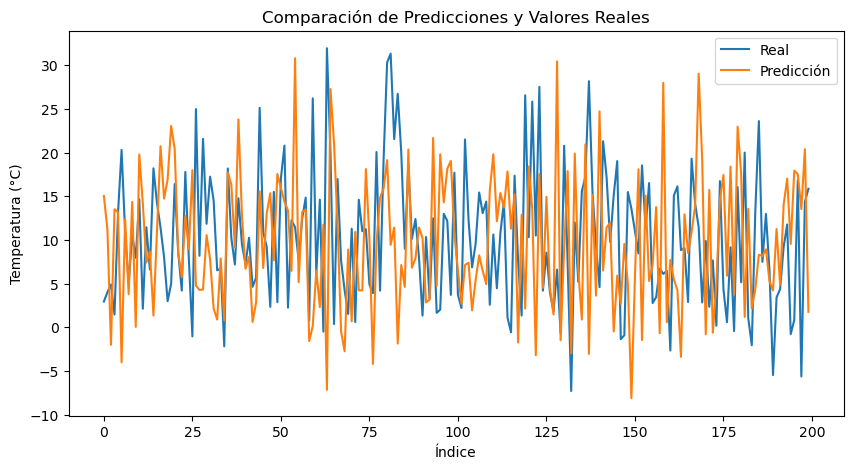

In [14]:
# Graficar la historia del entrenamiento
plt.figure(figsize=(12, 5))
plt.plot(history_adjusted.history['mae'], label='MAE de entrenamiento')
plt.plot(history_adjusted.history['val_mae'], label='MAE de validación')
plt.title('Error Absoluto Medio (MAE) durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Generar predicciones
predictions = model_adjusted.predict(test_dataset)

# Comparar con los valores reales
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(y_true[:200], label='Real')
plt.plot(predictions[:200], label='Predicción')
plt.title('Comparación de Predicciones y Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Temperatura (°C)')
plt.legend()
plt.show()
